<a href="https://colab.research.google.com/github/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial125_semantic_segmentation_using_Xfer_learning_VGG_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video link: https://youtu.be/t258JtqSolc

**Multiclass semantic segmentation - Using VGG16 for feature extraction and XGBoost for segmentation**


The dataset used in this video can be downloaded from the link below. This dataset can be used to train and test machine learning algorithms designed for multiclass semantic segmentation. Please read the Readme document for more information. 
https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view?usp=sharing

To annotate your own images, please visit www.apeer.com
<p>

**Installing XGBoost**

<p>
pip install xgboost  
    <p>
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)   

<p>



In [ ]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [ ]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation
num_images = 50  #Total 1600 available but we can use a subset for speedy training

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/*.tif")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 1) for image in image_names_subset] #SM backbones use 3 channel images, so let us read images in color.
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)


In [ ]:
print("Total images in the original dataset are: ", len(image_names))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  1600
Image data shape is:  (50, 128, 128, 3)
Mask data shape is:  (50, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [1 2 3 4]


In [ ]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [ ]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0



58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [ ]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
#Now, let us apply feature extractor to our training data
features = new_model.predict(X_train)

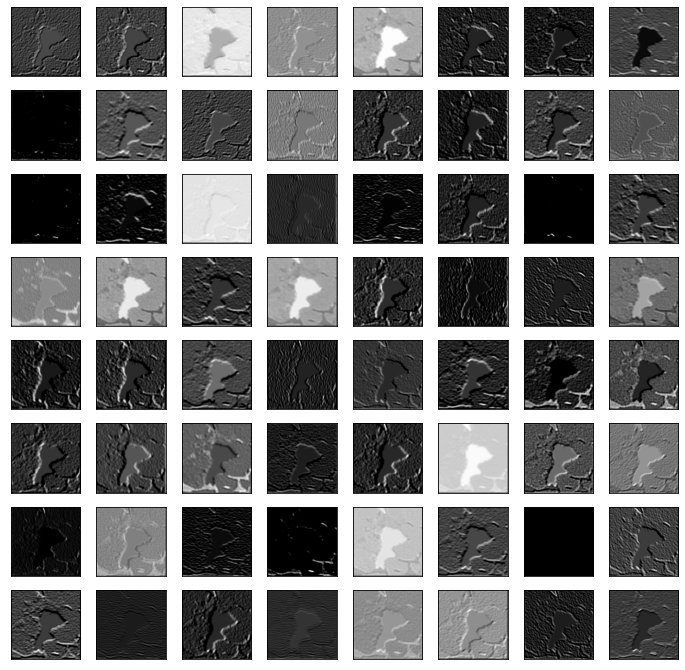

In [ ]:
#Plot features to view them
plt.figure(figsize=(12, 12))
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [ ]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels
print(X.shape)

(655360, 64)


In [ ]:
#Reshape Y to match X
Y = y_train.reshape(-1)
print(Y.shape)

(655360,)


In [ ]:
np.unique(Y)

array([0, 1, 2, 3])

In [ ]:
#RANDOM FOREST, if interested in using it instead of xgboost. 
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(n_estimators = 10, random_state = 42)

In [ ]:
#XGBOOST
#Documentation for GPU: https://xgboost.readthedocs.io/en/latest/gpu/index.html#
import xgboost as xgb

model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)  #Define gpu_id, otherwise it uses CPU and computation would be very slow. 


In [ ]:
# Train the model on training data
model.fit(X, Y) 

In [ ]:
#Save model for future use
import pickle
filename = '/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial125_model_XG_500_imgs.sav'


In [ ]:
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#Start segmenting future images

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
X_test_features=new_model.predict(X_test)
X_test_features=X_test_features.reshape(-1, X_test_features.shape[3])
print(X_test_features.shape)

(163840, 64)


In [ ]:
y_pred = loaded_model.predict(X_test_features)
print(y_pred.shape)

(163840,)


In [ ]:
ground_truth = y_test.reshape(-1)
print(ground_truth.shape)

(163840,)


In [ ]:
#Pixel accuracy - not a good metric for semantic segmentation
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(ground_truth, y_pred))

Accuracy =  0.93341064453125


In [ ]:
#IOU
from keras.metrics import MeanIoU

#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth, y_pred)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7918352


In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

#

[[1.31280e+04 4.07000e+02 4.38000e+02 0.00000e+00]
 [1.23900e+03 9.36300e+03 5.60700e+03 0.00000e+00]
 [7.34000e+02 2.26300e+03 1.28031e+05 4.80000e+01]
 [0.00000e+00 0.00000e+00 1.74000e+02 2.40800e+03]]
IoU for class1 is:  0.82327855
IoU for class2 is:  0.49594787
IoU for class3 is:  0.93252486
IoU for class4 is:  0.91558933


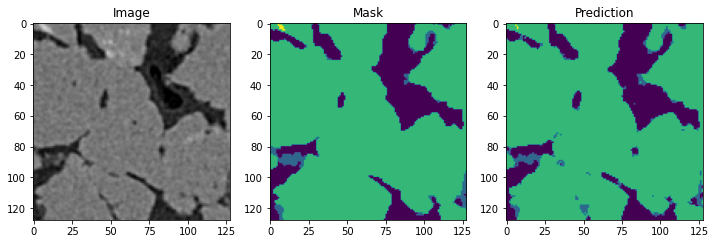

In [ ]:
import random
img_number = random.randint(0, len(X_test)-1)
img = X_test[img_number]
img=np.expand_dims(img, axis=0)

img_features=new_model.predict(img)
img_features = img_features.reshape(-1, img_features.shape[3])
mask = y_test[img_number]

prediction = loaded_model.predict(img_features)
predicted_mask = prediction.reshape(mask.shape[0], mask.shape[1])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img[0], cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_mask)
plt.show()